# Solar Envelope

In this workshop we will learn how to compute the solar envelop of the building based on a voxelized building envelope.

## 0. Initialization
Importing all necessary libraries and specifying the inputs

In [1]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
from ladybug.sunpath import Sunpath

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

## 1. Import Meshes (context + envelope)

### 1.1. Load Meshes

In [2]:
envelope_path = os.path.relpath('../data/raw data/optional_envelope.obj')
context_path = os.path.relpath('../data/raw data/immediate_context.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

True
False


In [3]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/dynamic output/voxelized_envelope.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)

## 3. Sun Vectors

### 3.1. Compute Sun Vectors

In [4]:
# initiate sunpath
sp = Sunpath(longitude=4.3571, latitude=52.0116)

# define sun hours : A list of hours of the year for each sun vector
# there are 8760 hours in a year, so the following integers refer to specific hours throughout the year
hoys = []
sun_vectors = []
day_multiples = 90
# for each day of the year ...
for d in range(365):
    # if it is one of the multiples
    if d%day_multiples==0:
        # for each hour of the day ...
        for h in range(24):
            # compute the hoy (hour of the year)
            hoy = d*24 + h
            # compute the sun object
            sun = sp.calculate_sun_from_hoy(hoy)
            # extract the sun vector (the direction that the sun ray travels toward)
            sun_vector = sun.sun_vector.to_array()
            # evidently, if the Z component of sun vector is positive, 
            # the sun is under the horizon 
            if sun_vector[2] < 0.0:
                hoys.append(hoy)
                sun_vectors.append(sun_vector)
                
sun_vectors = np.array(sun_vectors)
# compute the rotation matrix 
Rz = tm.transformations.rotation_matrix(np.radians(36.324), [0,0,1])
# Rotate the sun vectors to match the site rotation
sun_vectors = tm.transform_points(sun_vectors, Rz)
print(sun_vectors.shape)

(56, 3)


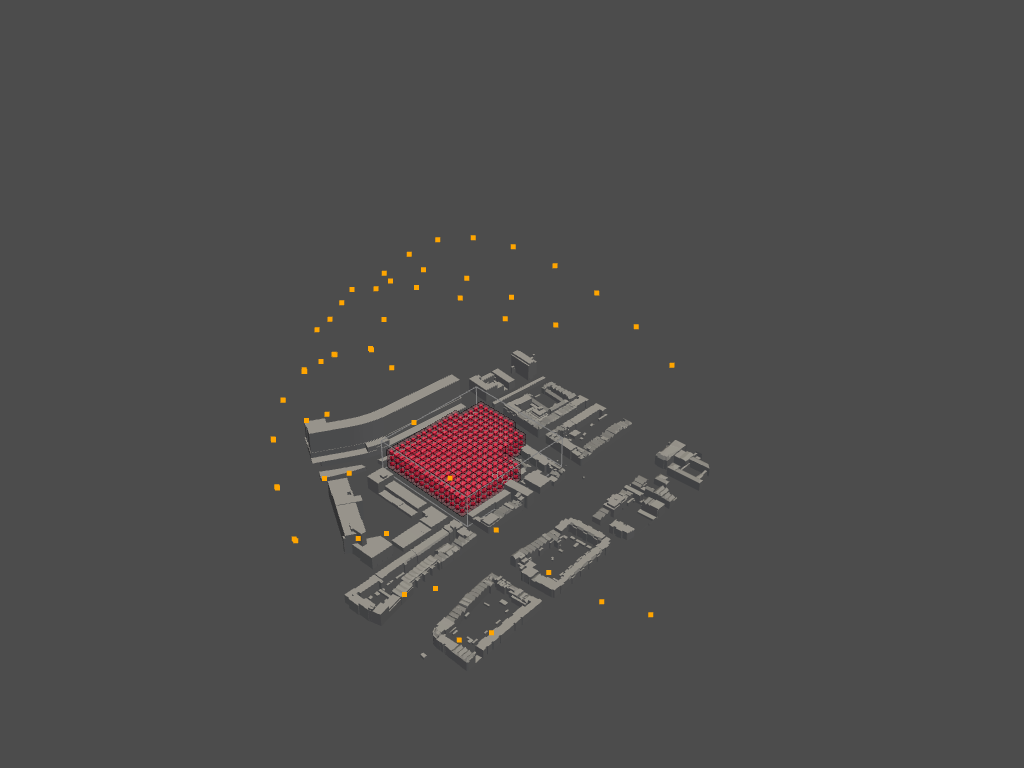

[(986.8266254921544, 980.1862937361667, 1113.9439327913703),
 (1.9852416455020432, -4.65509011048573, 129.10254894471785),
 (0.0, 0.0, 1.0)]

In [5]:
# Visualize the mesh using pyvista plotter
# initiating the plotter
p = pv.Plotter(notebook=True)

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# add the sun locations, color orange
p.add_points( - sun_vectors * 300, color='#ffa500')

# plotting
p.show()

## 4. Compute Intersection of Sun Rays with Context Mesh

### 4.1. Preparing the List of Ray Directions and Origins

In [6]:
# constructing the sun direction from the sun vectors in a numpy array

converted_sun_vectors = sun_vectors.astype('float16')
sun_dirs = -np.array(converted_sun_vectors)

# exract the centroids of the envelope voxels
vox_cens = envelope_lattice.centroids

# shooting from the voxel centroids towards the sun to check if voxels are in the shadows of context buildings
ray_dir = []
ray_src = []
for v_cen in vox_cens:
    for s_dir in sun_dirs:
        ray_dir.append(s_dir)
        ray_src.append(v_cen)

# shooting from the voxel centroids in the opposite way of the sun to see if the voxels cast shadows on context buildings
ray_dir2 = []
ray_dir2_index = []
for v_cen in vox_cens:
    for s_dir in converted_sun_vectors:
        ray_dir2.append(s_dir)

# converting the list of directions and sources to numpy array
ray_dir = np.array(ray_dir)
ray_src = np.array(ray_src)
ray_dir2 = np.array(ray_dir2)


"""
# Further info: this is the vectorised version of nested for loops
ray_dir = np.tile(sun_dirs, [len(vox_cens),1])
ray_src = np.tile(vox_cens, [1, len(sun_dirs)]).reshape(-1, 3)
"""

print("number of voxels to shoot rays from :",vox_cens.shape)
print("number of rays per each voxel :",sun_dirs.shape)
print("number of rays to be shooted :",ray_src.shape)

number of voxels to shoot rays from : (672, 3)
number of rays per each voxel : (56, 3)
number of rays to be shooted : (37632, 3)


NameError: name 'ray_src2' is not defined

### 4.2. Computing the Intersection

In [10]:
# computing the intersections of rays with the context mesh
tri_id, ray_id = context_mesh.ray.intersects_id(ray_origins=ray_src, ray_directions=ray_dir, multiple_hits=False)

In [11]:
# computing the intersections of the inverted rays with the context mesh
tri_id2, ray_id2 = context_mesh.ray.intersects_id(ray_origins=ray_src, ray_directions=ray_dir2, multiple_hits=False)

## 5. Aggregate Simulation Result in the Sun Access Lattice

### 5.1. Compute the percentage of time that each voxel sees the sun

In [18]:
# initializing the hits list full of zeros
hits = [0]*len(ray_dir)
hits2 = [0]*len(ray_dir2)

# setting the rays that had an intersection to 1
for id in ray_id:
    hits[id] = 1 # sun access
for id2 in ray_id2:
    hits2[id2] = 1 # sun blockage
    
# 
sun_count=len(sun_dirs)
vox_count=len(vox_cens)

# initiazing the lists of voxel that have access to the sun and voxels that are being blocked
vox_sun_acc = []
vox_sun_blockage = []


for v_id in range(vox_count):
    int_count = 0 # sun access
    int_count2 = 0 #sun blockacge
    for s_id in range(sun_count):
        r_id = s_id + v_id * sun_count

        # summing intersections
        int_count += hits[r_id]
        # cheking if the ray gets hit on the way to the voxel, if yes then add to int_count2
        if hits[r_id]==0:
            int_count2 += hits2[r_id]

    # computing the percentage of rays that did not have an intersection --> could see the sun
    sun_access = 1.0 - int_count/sun_count 
    # computing the percentage of rays that did  have an intersection -->  could not see the sun
    sun_blockage = 1.0 - int_count2/sun_count

    #add the ratio to the list
    vox_sun_acc.append(sun_access)
    vox_sun_blockage.append(sun_blockage)

# converting the lists to a numpy array
vox_sun_acc = np.array(vox_sun_acc)
vox_sun_blockage = np.array(vox_sun_blockage)


### 5.2. Store sun access information in a Lattice

In [28]:
# getting the condition of all voxels: are they inside the envelope or not
env_all_vox = envelope_lattice.flatten()

# all voxels sun access
all_vox_sun_acc = []
all_vox_sun_blockage = []

# v_id: voxel id in the list of only interior voxels
v_id = 0

# for all the voxels, place the interiority condition of each voxel in "vox_in"
for vox_in in env_all_vox:
    # if the voxel was inside...
    if vox_in == True:
        # read its value of sun access and append it to the list of all voxel sun access
        all_vox_sun_acc.append(vox_sun_acc[v_id])
        all_vox_sun_blockage.append(vox_sun_blockage[v_id])
        # add one to the voxel id so the next time we read the next voxel
        v_id += 1
    # if the voxel was not inside... 
    else:
        # add 0.0 for its sun access
        all_vox_sun_acc.append(0.0)
        all_vox_sun_blockage.append(0.0)

# convert to array
sunacc_array = np.array(all_vox_sun_acc)
sunblockage_array = np.array(all_vox_sun_blockage)

# reshape to lattice shape
sunacc_array = sunacc_array.reshape(envelope_lattice.shape)
sunblockage_array = sunblockage_array.reshape(envelope_lattice.shape)

# convert to lattice
sunacc_lattice = tg.to_lattice(sunacc_array, envelope_lattice)
sunblockage_lattice = tg.to_lattice(sunblockage_array, envelope_lattice)

print(sunacc_lattice.shape)


ValueError: cannot reshape array of size 672 into shape (18,17,5)

### 5.3. Visualize the sun access lattice

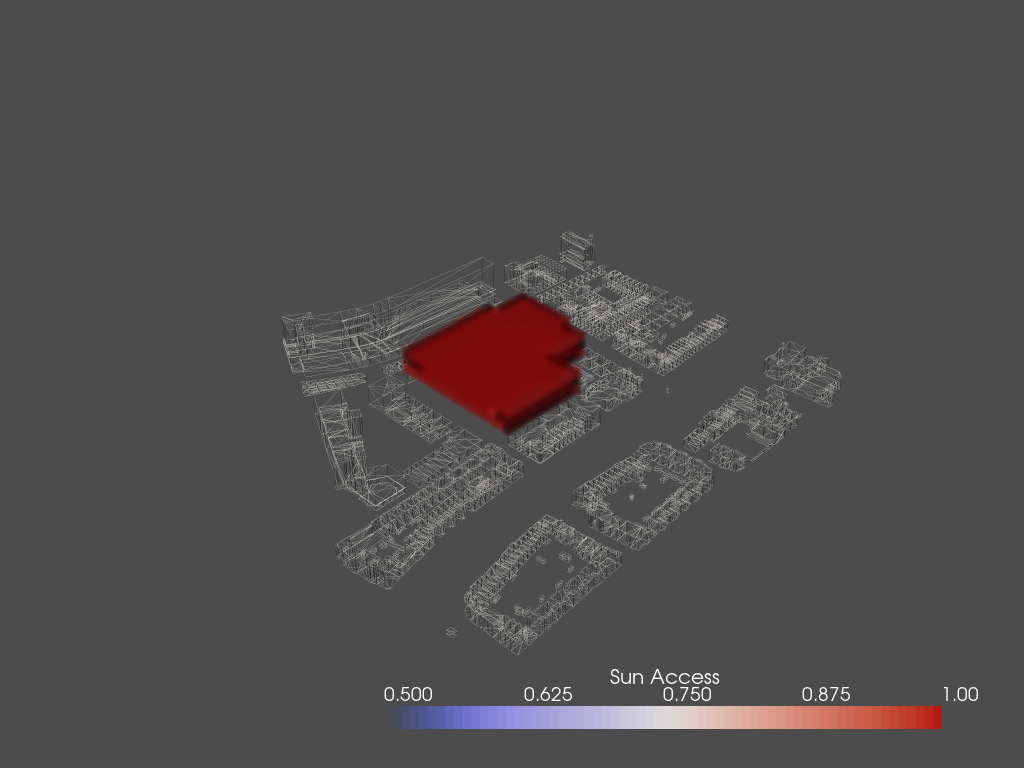

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [24]:
# initiating the plotter
p = pv.Plotter(notebook=True)

l = sunacc_lattice
# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Sun Access"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6])*1.5
p.add_volume(grid, cmap="coolwarm", clim=[0.5, 1.0],opacity=opacity, shade=True)

# plotting
p.show()

## 6. Save Sun Access Lattice into a CSV

In [25]:
# save the sun access latice to csv

csv_path = os.path.relpath('../data/sun_access.csv')
sunacc_lattice.to_csv(csv_path)

### Credits

In [26]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Solar Envelope"